# 21_KoChatGPT_upgrade_Project

## to do
- [O] 코드 주석 달면서 이해하기

## upgrade를 위한 기법들
- [O] 기존 데이터셋 추가 정제하기
- [ ] 더 많은 데이터셋 사용해서 SFT, RM 모델 훈련시키기
- [△] 하이퍼파라미터 서치
- [O] 생성된 답변에 대한 주관적 평가 보완하기 위한 정량적 metric 도입하기
    - BLEU 스코어를 도입하여 정량적으로 답변을 평가하고자 하였다.
- [ ] 다양한 Instruction Tuning 및 Prompting 기법들도 적용해보기
- [ ] 더 큰 파라미터 스케일을 가진 모델을 사용해보기
- [ ] 더 효율적인 연산을 수행할 수 있는 LoRA의 적용 또는새로운 Instruction Tuning 및 reward ranking 알고리즘을 도입해보기


In [126]:
# pytorch, cuda 버전 확인
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

Torch version:1.12.1
Cuda version: 11.3
transformers                  4.28.0


## Load Dataset & Model

In [127]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

# 모델, 토큰나이저 불러오기
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#decoding 성능 확인
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

# hf 모델 사용해 텍스트 생성
output_beam = model.generate(input_ids, # 모델에 입력으로 전달되는 토큰id 리스트 또는 텐서
                             max_length=max_length, # 생성된 텍스트 최대 길이
                             num_beams=7, # beam search 빔의 개수(다양성)
                             no_repeat_ngram_size=2,#생성된 텍스트에서 반복되는 N-gram(연속된 토큰 그룹)을 허용하지 않을 크기를 나타내는 정수
                             do_sample=True, #텍스트를 샘플링할지 여부
                             top_p=0.90 #0.9 이상 확률 토큰만 선택
                            )
# 결과 디코딩
print(output_beam)
print(tokenizer.decode(output_beam[0]))

In [4]:
# 인코딩 성능 확인
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


### 데이터셋 확인
- STF, RM, PPO 데이터셋을 불러오고 분포를 확인해보자.

In [ ]:
# STF
import json 
data_path_1_SFT = '../../KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 

with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

In [100]:
tokens_list = [len(data['prompt']) for data in list_data_dict]
tokens_list

[13,
 14,
 7,
 7,
 5,
 8,
 11,
 44,
 8,
 26,
 72,
 5,
 37,
 17,
 27,
 25,
 20,
 28,
 15,
 14,
 24,
 16,
 16,
 41,
 36,
 6,
 10,
 18,
 65,
 17,
 14,
 11,
 14,
 20,
 31,
 23,
 20,
 29,
 25,
 27,
 22,
 42,
 11,
 14,
 18,
 30,
 15,
 22,
 11,
 42,
 11,
 51,
 37,
 8,
 19,
 6,
 29,
 28,
 13,
 36,
 33,
 14,
 16,
 66,
 49,
 23,
 22,
 39,
 25,
 15,
 11,
 12,
 29,
 20,
 20,
 49,
 8,
 17,
 18,
 15,
 5,
 11,
 14,
 62,
 22,
 27,
 14,
 13,
 32,
 14,
 11,
 14,
 8,
 34,
 12,
 18,
 29,
 26,
 9,
 22,
 33,
 12,
 11,
 15,
 25,
 11,
 27,
 93,
 14,
 22,
 9,
 18,
 49,
 22,
 19,
 19,
 3,
 11,
 31,
 19,
 42,
 24,
 6,
 44,
 14,
 15,
 10,
 13,
 25,
 15,
 9,
 17,
 21,
 32,
 17,
 23,
 12,
 36,
 34,
 15,
 16,
 23,
 10,
 18,
 62,
 25,
 37,
 49,
 10,
 6,
 41,
 10,
 27,
 22,
 24,
 24,
 41,
 21,
 7,
 39,
 22,
 32,
 27,
 5,
 23,
 38,
 23,
 36,
 20,
 27,
 12,
 12,
 17,
 22,
 18,
 15,
 17,
 25,
 13,
 11,
 13,
 33,
 27,
 46,
 51,
 31,
 16,
 8,
 23,
 22,
 17,
 15,
 30,
 26,
 19,
 22,
 16,
 9,
 9,
 22,
 19,
 13,
 10,
 21,
 27

In [107]:
import matplotlib.pyplot as plt
import numpy as np
document_lengths = tokens_list

# 히스토그램 그리기
def token_hist(document_lengths):
    plt.hist(document_lengths, bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('sentence length')
    plt.ylabel('frequencey')
    plt.title('sentence length distribution')

    # 데이터 정렬 후 백분위수 계산
    sorted_lengths = np.sort(document_lengths)
    percentile_90 = np.percentile(sorted_lengths, 95)

    # 90% 백분위수에 해당하는 수직선 그리기
    plt.axvline(x=percentile_90, color='red', linestyle='--', label='95th Percentile')
    plt.legend()
    plt.show()
    print("95%:", percentile_90)

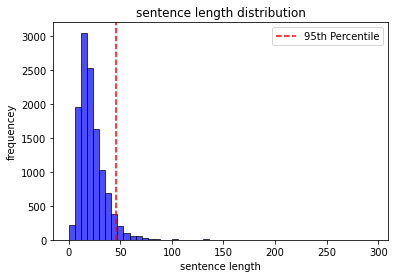

95%: 46.0


In [108]:
token_hist(document_lengths)

전체 prompt는 100 미만의 길이로 구성되어 있고 길이가 46일때 전체 데이터셋의 95%를 포함하고 있다. 

## completion에 대한 분포

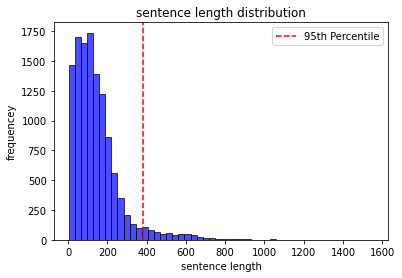

95%: 382.0


In [109]:
tokens_list = [len(data['completion']) for data in list_data_dict]
token_hist(tokens_list)


전체 답변 길이는 382일때 95%의 데이터를 포함하고 있다.

In [111]:
# RM
data_path_2_RM = '../../KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'

with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

In [ ]:
tokens_list = [len(data['completion']) for data in list_data_dict]
token_hist(tokens_list)


In [7]:
## PPO
data_path_3_PPO = '../../KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'

with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

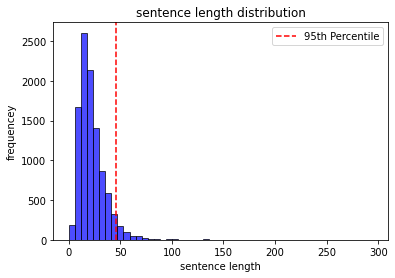

95%: 46.0


In [112]:
tokens_list = [len(data['prompt']) for data in list_data_dict]
token_hist(tokens_list)


## kogpt-2를 instruction dataset으로 STF 진행하기

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [114]:
# 모델, 토크나이저 불러오기
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)


GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [115]:
# 모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = '../../KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
            
        #400이하 데이터만    
        list_data_dict = [data for data in list_data_dict if len(data['completion']) <= 400]


        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        
        # prompt 형식 조정
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)
            
        # target 형식 조정
        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]
        
        # 토큰화
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100 #negative infinity

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


In [116]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [117]:
# SFT_dataset 클래스를 사용해 훈련셋을 만들고 data collator 인스턴스 제작
train_dataset = SFT_dataset(data_path_1_SFT='../../KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [118]:
# 훈련을 위한 마지막 단계로 Training arguments를 사용해 trainer 클래스 정의
training_args = TrainingArguments(
    output_dir="aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [119]:
# 훈련
trainer.train()
model.save_pretrained('aiffel/KoChatGPT/output_2_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.959900
1000,2.748900


### 하이퍼파라미터 서치
```Python
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

def objective(trial):
    # 하이퍼파라미터 튜닝 대상 설정
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16])
    warmup_steps = trial.suggest_int("warmup_steps", 0, 1000)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3)

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir=f"aiffel/KoChatGPT/test/{trial.number}",
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=8,
        warmup_steps=warmup_steps,
        prediction_loss_only=True,
        learning_rate=learning_rate,
        fp16=True
    )

    # Trainer 및 모델 설정
    trainer = Trainer(
        logger=TensorBoardLogger("logs/"),  # 로그 기록을 위한 TensorBoard 사용
        gpus=1,  # GPU 사용 여부 설정
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss")],  # Early stopping을 위한 Pruning 콜백
        max_epochs=num_train_epochs,
        num_sanity_val_steps=0,
    )

    model = YourModelClass()  # 여기에 모델 클래스를 정의하고 초기화하세요.

    # 학습 시작
    trainer.fit(model, train_dataloader)

    # 검증 데이터로 평가
    results = trainer.test(model, val_dataloader)

    # 최적화하려는 지표 (예: 검증 데이터의 손실) 반환
    return results[0]["val_loss"]

if __name__ == "__main__":
    study = optuna.create_study(
        direction="minimize",  # 손실을 최소화하려고 합니다.
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    )
    study.optimize(objective, n_trials=100)  # 100번의 하이퍼파라미터 조합을 시도합니다.

    print("Best trial:")
    trial = study.best_trial

    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

```

In [120]:
# 문장생성능력 확인
generator = pipeline('text-generation', model='aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 불고기용 고기의 종류와 양에 대한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기는 쇠고기와 함께 먹는 음식 중 하나입니다. 따라서 불고기를 먹을 수 있는 종류는 다양합니다. 예를 들어, 닭가슴살 스테이크, 오므라이스 샐러드 등이 있습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다.作)作)은 "리처드 닉슨"이 41대 부통령을 수행한 년도를 가리키는 말입니다.作)는 "리처드 닉슨"이 40대 부통령을 맡았던 년도를 의미합니다.作은 "리처드슨"이 50대 부통령

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다.子供共和國際空港)이라고 불립니다.子供公和国際空港이라는 뜻입니다.子供空和國際公港이라는 이름을 가진 항공사는 다음과 같습니다.\n\n1. 대한항공

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇으로써 미세먼지 정보를 알 수 없습니다. 미세먼지 예보를 확인해 보시는 것이 좋겠습니다.\n\n미세먼지 예보: 일반적으로 미세먼지는 주로 중국에서 발원하여 중국 전역으로 퍼져나가기 때문에 중국발 미세먼지가 유입될


## RM 설계 및 학습

In [121]:
!pip install chatgpt

In [17]:
! pip install chatgpt.dataset

ERROR: Could not find a version that satisfies the requirement chatgpt.dataset (from versions: none)
ERROR: No matching distribution found for chatgpt.dataset


In [20]:
!pip install "$HOME/aiffel/KoChatGPT/colossalai_ChatGPT_230319/"

Processing /aiffel/aiffel/KoChatGPT/colossalai_ChatGPT_230319
  Preparing metadata (setup.py) ... done
  Created wheel for chatgpt: filename=chatgpt-0.1.0-py3-none-any.whl size=46664 sha256=d7e2fdc9615d06a6e438c623f461a004c49f1cbc56a0aa9ced6cbcbda5e9d8f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-oc14qncq/wheels/79/25/c3/338e0c56a2253a8ea6c41e8692f6eb2409a3898c63b234b103
Successfully built chatgpt
  Attempting uninstall: chatgpt
    Found existing installation: chatgpt 2.2212.0
    Uninstalling chatgpt-2.2212.0:
      Successfully uninstalled chatgpt-2.2212.0


In [21]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

In [122]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [123]:
# 모델, 토크나이저
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
# rm 훈련시 사용할 ranking 데이터셋
with open('../../KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
#400이하 데이터만    
list_data_dict = [data for data in list_data_dict if len(data['prompt']) <= 46]

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 9739
after  data num: 29217
data example: 
{'prompt': '원피스의 원래 주인이 누구였어', 'chosen': '일럼, 그', 'rejected': '요?\n\n원피스의 원래 주인은 핑크 전복 볼몽 소사이어스 롱보우 왕자 (Pirate King Gol D. Roger) 입니다.'}


In [26]:
class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss

In [53]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


In [54]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 996.41it/s]


In [55]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
흑고래의 무게는 어느 정도야
######################################################################
## chosen ##
흑고래의 평균 몸무게는 약 25~40톤 정도이지만, 최대 몸무게는 50톤 이상에 이를 수 있습니다.
######################################################################
## rejected ##
흑고래의 무게는 매우 다양하게 달라집니다. 약 200kg에서 10톤까지 달라질 수 있습니다.


In [56]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [60]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [03:54<00:00, 234.55s/it]


In [61]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -2.4


In [62]:
torch.cuda.empty_cache()

## PPO

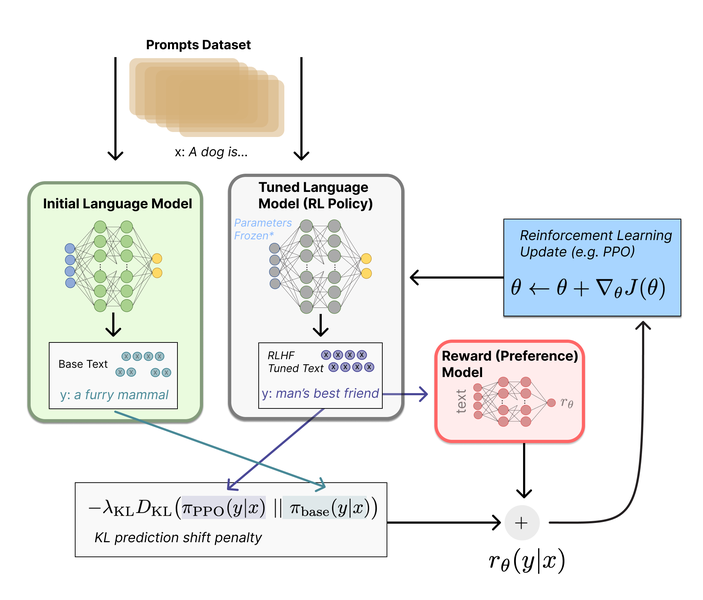

In [131]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer

from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [133]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='aiffel/KoChatGPT/output_2_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [134]:
# 옵티마이저, 모델 준비
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [135]:
with open('../../KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}
          
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [136]:
len(list_prompt)

12000

In [137]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [138]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_4_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:17<00:00,  5.86s/it]


In [139]:
# 생성능력 확인
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output


In [140]:

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'제가 AI 언어 모델이므로, 고기 한우를 맛보고 어떤 고기인지 판단할 수는 없습니다. 하지만 일반적으로 불고기용 고기 한우에 불고기된 고기를 추가하는 것은 가능합니다. 예를 들어, 불고기 된 고기 한우에 불고기 된 고기를 추가하면 맛있는 고기를 만들 수 있습니다. 일반적으로 불고기된 고기를 추가한 경우, 양념장에 고기를 추가하면 고기 맛을 더해줄 수 있을 것입니다. 해당 질문의 문맥이 부족하여 정확한 답변을 드리기 어렵습니다. 올리브오일, 감자, 고구마, 대추 등 다양한 식재료를 활용하여 고기를 추가할 수 있습니다. 문맥 파악, 추가하기 어려워 정확한 답변을 제공할 수 없습니다. 올리브 오일, 올리브 오일, 감자, 고구마, 감자 등 다양한 종류의 먹거리를 사용하여 고기 맛을 더하고 있습니다. 챗봇에 대해 자세한 정보를 알고 싶다면 온라인 검색 또는 전화상으로 검색하고 싶은 곳을 찾아가시면 더 많이 찾아보시기를 추천드립니다.曾し香 さけ さけ およよんよ う

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행한 년도는 1942년에 발생했습니다. 스미스는 1943년에 47대 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습

## 정량적 metric 도입

In [147]:
# 불고기용 고기 한우에요?
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 모델이 생성한 텍스트
model_output ="제가 AI 언어 모델이므로, 고기 한우를 맛보고 어떤 고기인지 판단할 수는 없습니다. 하지만 일반적으로 불고기용 고기 한우에 불고기된 고기를 추가하는 것은 가능합니다. 예를 들어, 불고기 된 고기 한우에 불고기 된 고기를 추가하면 맛있는 고기를 만들 수 있습니다. 일반적으로 불고기된 고기를 추가한 경우, 양념장에 고기를 추가하면 고기 맛을 더해줄 수 있을 것입니다. 해당 질문의 문맥이 부족하여 정확한 답변을 드리기 어렵습니다. 올리브오일, 감자, 고구마, 대추 등 다양한 식재료를 활용하여 고기를 추가할 수 있습니다. 문맥 파악, 추가하기 어려워 정확한 답변을 제공할 수 없습니다. 올리브 오일, 올리브 오일, 감자, 고구마, 감자 등 다양한 종류의 먹거리를 사용하여 고기 맛을 더하고 있습니다. 챗봇에 대해 자세한 정보를 알고 싶다면 온라인 검색 또는 전화상으로 검색하고 싶은 곳을 찾아가시면 더 많이 찾아보시기를 추천드립니다.曾し香 さけ さけ およよんよ う"
# 참조 텍스트 (리스트 형태로 여러 개의 참조 텍스트를 제공할 수도 있습니다)
reference_text = ["아니요, 이 고기는 미국산입니다.", "네 맞아요.", "네, 무려 한우 에이쁠 등급 고기입니다. 오늘만 싸게 팔고 있어요."]

# BLEU 스코어를 계산하는 함수
def calculate_bleu_score(model_output, reference_text):
    # Smoothing 함수를 사용하여 0으로 나누는 것을 방지합니다.
    smoothing = SmoothingFunction().method1
    # BLEU 스코어 계산
    bleu_score = sentence_bleu(reference_text, model_output, smoothing_function=smoothing)
    return bleu_score

# BLEU 스코어 계산
score1 = calculate_bleu_score(model_output.split(), [ref.split() for ref in reference_text])


In [152]:
# '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 모델이 생성한 텍스트
model_output = "리처드 닉슨은 41대 부통령직을 수행한 년도는 1942년에 발생했습니다. 스미스는 1943년에 47대 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다. 스미스는 1944년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1942년에 부통령직을 맡았습니다.莎佳次世在美公士)는 1941년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을 맡았습니다. 스미스는 1943년에 부통령직을"
# 참조 텍스트 (리스트 형태로 여러 개의 참조 텍스트를 제공할 수도 있습니다)
reference_text = ["잘 모르겠습니다.", 
                  "1953년부터 1961년 사이 입니다.", 
                  "1953년부터 1961년까지 총 8년간 입니다."]

# BLEU 스코어를 계산하는 함수
def calculate_bleu_score(model_output, reference_text):
    # Smoothing 함수를 사용하여 0으로 나누는 것을 방지합니다.
    smoothing = SmoothingFunction().method1
    # BLEU 스코어 계산
    bleu_score = sentence_bleu(reference_text, model_output, smoothing_function=smoothing)
    return bleu_score

# BLEU 스코어 계산
score2 = calculate_bleu_score(model_output.split(), [ref.split() for ref in reference_text])


In [153]:
#    '시카고 오헤어 국제공항은 어디에 있어',
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 모델이 생성한 텍스트
model_output = "시카고 오헤어 국제공항은 미국에 있는 세인트애리 주 시 레이크 오클리에 위치해 있습니다."
# 참조 텍스트 (리스트 형태로 여러 개의 참조 텍스트를 제공할 수도 있습니다)
reference_text = ["저도 잘 모르겠습니다.", 
                  "오헤어 국제공항은 미국 일리노이주 시카고에 있습니다.", 
                  "미국 시카고에 있습니다."]

# BLEU 스코어를 계산하는 함수
def calculate_bleu_score(model_output, reference_text):
    # Smoothing 함수를 사용하여 0으로 나누는 것을 방지합니다.
    smoothing = SmoothingFunction().method1
    # BLEU 스코어 계산
    bleu_score = sentence_bleu(reference_text, model_output, smoothing_function=smoothing)
    return bleu_score

# BLEU 스코어 계산
score3 = calculate_bleu_score(model_output.split(), [ref.split() for ref in reference_text])


In [154]:
#    '오늘 미세먼지 어때?']
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 모델이 생성한 텍스트
model_output = "미세먼지 문제가 심각하다면, 매일 가습기나 청소기를 사용하거나, 실내공기정화 시스템을 사용하는 등 다양한 방법으로 문제를 해결할 수 있습니다. 미세먼지에 대한 대처 방법도 알아보세요. 또한 미세먼지 제거를 위해서는 외출 시 항상 깨끗한 실내 환경을 유지하는 것도 좋은 방법입니다. 미세먼지 제거를 위해 공기청정기나 공기청정기를 사용하는 것은 미세먼지의 수를 줄여 주는 방법 중 하나입니다. 신으로아스터교에서는 공기청정기와 공기청정기 같은 수면과 보호용품을 사용하여 미세먼지를 효과적으로 제거할 수 있습니다.神神敎에서는 공기정화 및 공기청정기를 사용하여 미세먼지를 줄이는 방법을 제안하고 있습니다.神敎는 공기정화 시스템을 사용하여 미세먼지의 양을 줄이는 방법 중 하나입니다.神敎는 공기정화 기능이 있는 공기정화장치도 도입하고 있습니다.臣敎는 미세먼지의 수를 줄이는 방법 중 하나입니다.神敎에서는 공기를 깨끗하게 하고 공기질을 줄이기 위해 공기청정기와 공기청정기를 사용기를 이용하여 미세먼지를 효과적으로 제거할 수 있습니다.申子神敎는 공기정화장치 또한 사용하고 있어, 각 상황에 따라 수치와 방법을"
# 참조 텍스트 (리스트 형태로 여러 개의 참조 텍스트를 제공할 수도 있습니다)
reference_text = ["현재 서울의 미세먼지 농도는 206 마이크로그램으로, 중부지방은 ‘매우 나쁨’ 단계가 계속되고 있습니다. 남부지방은 150 마이크로그램 안팎으로 어제보다 농도가 낮지만 여전히 미세먼지 경보나 주의보가 내려진 곳이 많습니다. 전국의 미세먼지 농도는 ‘매우 나쁨’ 단계가 예상됩니다",
                  "오늘은 미세먼지 농도가 매우 나쁘므로 실외 활동을 자제하는 게 좋습니다.", 
                  "오늘 미세먼지는 매우 좋습니다. 가족들과 함께 바깥 활동을 즐기세요!",
                 "죄송합니다. 잘 모르겠습니다."]

# BLEU 스코어를 계산하는 함수
def calculate_bleu_score(model_output, reference_text):
    # Smoothing 함수를 사용하여 0으로 나누는 것을 방지합니다.
    smoothing = SmoothingFunction().method1
    # BLEU 스코어 계산
    bleu_score = sentence_bleu(reference_text, model_output, smoothing_function=smoothing)
    return bleu_score

# BLEU 스코어 계산
score4 = calculate_bleu_score(model_output.split(), [ref.split() for ref in reference_text])


In [89]:
# 기존 결과 출력(데이터 전처리 전)
print("BLEU 스코어:", score1)
print("BLEU 스코어:", score2)
print("BLEU 스코어:", score3)
print("BLEU 스코어:", score4)


BLEU 스코어: 0.0015264903927896083
BLEU 스코어: 0
BLEU 스코어: 0.0305960433651666
BLEU 스코어: 0.009629943614188135


In [155]:
# 데이터 전처리 진행 후 결과
print("BLEU 스코어:", score1)
print("BLEU 스코어:", score2)
print("BLEU 스코어:", score3)
print("BLEU 스코어:", score4)


BLEU 스코어: 0
BLEU 스코어: 0
BLEU 스코어: 0.03986357128268015
BLEU 스코어: 0.002196494988556465


기존 결과에 비해 일부 텍스트에서 BLEU 스코어가 상승하였다. '시카고 오헤어 국제공항은 어디에 있어'라는 질문에 대한 BLEU 스코어가 상승하였다. 그러나 AI 모델의 답변은 사실이 아니다.

## 회고
### 새롭게 알게된 점
- 데이터셋 전처리를 수행했더니 기존 결과에 비해 반복되는 답변이 증가한 것 같다.
- STF, RF, PPO에서 prompt와 complimetion 중 어떤 text가 모델의 maxlength에 영향을 미치는지 헷갈렸는데 STF는 complimention, RF는 prompt의 길이를 고려해야 한다고 한다.

### kpt
- K: 코드 이해하면서 프로젝트 수행하기
- P: 시간문제로 제안된 기법들을 전부 적용하지 못했다.
- T: 하이퍼파라미터 서치 해보기, 이론 공부 좀 더 하기
